# Classify SEC 10K/Q Filings to Industry Codes Based on the MDNA Text Column

## Introduction

### Objective

The purpose of this notebook is to address the following question: Can we train a model to detect the broad industry category of a company from the text of Management Discussion & Analysis (**MD&A**) section in SEC filings? 

This notebook provides a template for the use of text data in U.S. Securities and Exchange Commission (SEC) filings, matching industry codes, adding NLP scores, and creating a *multimodal* training dataset. The multimodal dataset is then used for training a model for *multiclass* classification tasks.

### Curating Input Data

This example notebook demonstrates how to train a model on a synthetic training dataset that's curated using the SEC Forms retrieval tool provided by the [SageMaker JumpStart Industry Python SDK](https://pypi.org/project/smjsindustry/). You'll download a large number of SEC 10-K/Q forms for companies in the S&P 500 from 2000 to 2019. A separate column of the dataframe contains the **MD&A** section of the filings. The **MD&A** section is chosen because it is the most popular section used in the finance industry for natural language processing (NLP). The [SIC industry codes](https://www.osha.gov/data/sic-manual) are also used for matching to those in the [NAICS system](https://www.census.gov/naics/).

>**<span style="color:RED">Legal Disclaimer</span>**: 
>This example notebook is for demonstrative purposes only. It is not financial advice and should not be relied on as financial or investment advice.

### General Steps
This notebook takes the following steps:
1. Prepare training and testing datasets.
2. Add NLP scores to the MD&A text features.
3. Train the AutoGluon model for classification on the extended dataframe of MD&A text and NLP scores.
4. Deploy the endpoint for model inference.
5. Test the endpoint.

## Kernel and SageMaker Setup

Recommended kernel is **conda_python3**.

Ensure AutoGluon images information is available in SageMaker Python SDK.

In [31]:
!pip install -q -U "sagemaker>=2.66"

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [8]:
import sagemaker

session = sagemaker.Session()
region = session._region_name
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
mnist_folder = "jumpstart_industry_mnist"
train_instance_type = "ml.c5.2xlarge"
inference_instance_type = "ml.m5.xlarge"

## Load Data, SDK, and Dependencies

The following code cells download the `smjsindustry` SDK, dependencies, and dataset from an Amazon S3 bucket prepared by SageMaker JumpStart Industry. You will learn how to use the `smjsindustry` SDK which contains various APIs to curate SEC datasets. The dataset in this example was synthetically generated using the `smjsindustry` package's SEC Forms Retrieval tool.

In [9]:
notebook_artifact_bucket = f"jumpstart-cache-prod-{region}"
notebook_data_prefix = "smfinance-notebook-data/mnist"
notebook_sdk_prefix = "smfinance-notebook-dependency/smjsindustry"

In [10]:
# Download dataset
data_bucket = f"s3://{notebook_artifact_bucket}/{notebook_data_prefix}"
!aws s3 sync $data_bucket ./ --exclude "*" --include "*.csv"

Install `smjsindustry` package from `whl` artifact running the following code block. Alternatively, we can also use `pip install smjsindustry==1.0.0`.

In [35]:
# Install smjsindustry SDK
sdk_bucket = f"s3://{notebook_artifact_bucket}/{notebook_sdk_prefix}"
!aws s3 sync $sdk_bucket ./

!pip install --no-index smjsindustry-1.0.0-py3-none-any.whl

download: s3://jumpstart-cache-prod-us-west-2/smfinance-notebook-dependency/smjsindustry/smjsindustry-1.0.0-py3-none-any.whl to ./smjsindustry-1.0.0-py3-none-any.whl
Processing ./smjsindustry-1.0.0-py3-none-any.whl
smjsindustry is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


## Import Packages

In [36]:
import os
import boto3
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import tarfile
import smjsindustry
import sagemaker
from sagemaker.estimator import Estimator

from smjsindustry import NLPScoreType
from smjsindustry import NLPScorer
from smjsindustry import NLPScorerConfig
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)

>**Note**:
Step 1 and Step 2 will show you how to preprocess the training data and how to add MD&A Text features and NLP scores. 
</br>You can also opt to use our provided preprocessed data `sample_train_nlp_scores.csv` and `sample_test_nlp_scores.csv` skip Step 1&2 and directly go to Step 3.</br>

## Step 1: Prepare a Dataset

Here, we read in the dataframe curated by the SEC Retriever that is already prepared as an example. The use of the Retriever is described in another notebook provided, `SEC_Retrieval_Summarizer_Scoring.ipynb`. The industry codes shown here correspond to those in the [NAICS system](https://www.census.gov/naics/). We also attached the industry codes from [Standard Industrial Classification (SIC) Manual](https://www.osha.gov/data/sic-manual).

Because 10-K/Q firms are filed once a quarter, each firm shows up several instances in the dataset. 
When separating the dataset into train and test sets, we made sure that firms only appear in either the train or the test dataset, not in both. This ensures that the models are not able to memorize the text of a firm in the train dataset and then use it to classify firms in the test dataset. 

The classification task here appears trivial, but it is not; the MD&A section of the forms includes very long texts. In a separate analysis, we count the number of tokens (words) in each MD&A section for 12,144 filings, and obtain a mean of 5,307 tokens (sd=3,598 and interquartile range of 3140 to 6505). Transformer models, such as BERT, usually handle maximum sequence lengths of 512 or 1024 tokens. Therefore, it is unlikely that this classification task will benefit from recent advances in transformer models.

>**<span style="color:RED">Legal Disclaimer</span>**: 
>This example notebook uses data obtained from the SEC EDGAR database. You are responsible for complying with EDGAR’s access terms and conditions located in the [Accessing EDGAR Data](https://www.sec.gov/os/accessing-edgar-data) page.

#### Process the raw data

In [37]:
%%time
# READ IN THE DATASETS (The file sizes are large. They are about 1 GB in total)
train_df = pd.read_csv("sec_ind_train.csv", low_memory=False)
test_df = pd.read_csv("sec_ind_test.csv", low_memory=False)

CPU times: user 5.68 s, sys: 1.14 s, total: 6.82 s
Wall time: 6.84 s


In [38]:
# Remove the very small classes to simplify, if needed
train_df = train_df[train_df.industry_code != "C"]
train_df = train_df[train_df.industry_code != "F"]
test_df = test_df[test_df.industry_code != "C"]
test_df = test_df[test_df.industry_code != "F"]

You can find in the following cells that there are over 11,000 for the train dataset and over 3,000 for the test dataset. Note that there's a label (class) imbalance underlying in the dataset. 

In [39]:
# Show classes
print(train_df.shape, test_df.shape)
train_df.groupby("industry_code").count()

(11680, 2) (3209, 2)


,MDNA
industry_code,
B,658
D,5005
E,1070
G,1034
H,1840
I,2073


In [40]:
test_df.groupby("industry_code").count()

,MDNA
industry_code,
B,409
D,1233
E,446
G,404
H,423
I,294


For demonstration purposes, take a sample from the original dataset to reduce the time for training.

In [41]:
sample_train_df = train_df.groupby("industry_code", group_keys=False).apply(
    pd.DataFrame.sample, n=80, random_state=12
)

In [42]:
sample_train_df.groupby("industry_code").count()

,MDNA
industry_code,
B,80
D,80
E,80
G,80
H,80
I,80


In [43]:
sample_test_df = test_df.groupby("industry_code", group_keys=False).apply(
    pd.DataFrame.sample, n=20, random_state=12
)

In [44]:
sample_test_df.groupby("industry_code").count()

,MDNA
industry_code,
B,20
D,20
E,20
G,20
H,20
I,20


In [45]:
# Save the smaller datasets for use
sample_train_df.to_csv("sample_train.csv", index=False)
sample_test_df.to_csv("sample_test.csv", index=False)

## Step 2: Add NLP scores to the MD&A Text Features

Here we use the NLP scoring API to add three additional numerical features to the dataframe for a better classification performance. The columns will carry scores of the various attributes of the text. 

NLP scoring delivers a score as the fraction of words in a document that are in one of our internal scoring word lists. You can provide your own word list to calculate the NLP scores, such as negative, positive, risk, uncertainty, certainty, litigious, fraud and safe word lists. 

The approach taken here does not use human-curated word lists such as the popular dictionary from [Loughran and McDonald](https://sraf.nd.edu/textual-analysis/resources/), widely used in academia. Instead, the word lists here are generated from word embeddings trained on standard large text corpora where each word list comprises words that are close to the concept word (e.g. "risk") in embedding space. These word lists may contain words that a human may list out, but may still occur in the context of the concept word. 

You can also calculate your own scoring type by specifying a new word list.

**Technical notes**:

1. The data loader accesses a container to process the request. There might be some latency when starting up the container, which accounts for a few initial minutes. The actual filings extraction occurs after this. 
2. The data loader only supports processing jobs with only one instance at the moment.
3. Users are not charged for the waiting time used when the instance is initializing (this takes 3-5 minutes). 
4. The name of the processing job is shown in the run time log.  
5. You can also access the processing job from the [SageMaker console](https://console.aws.amazon.com/sagemaker). On the left navigation pane, choose Processing, Processing job.

### Construct a SageMaker processor for NLP scoring

The processing job runs on a `ml.c5.18xlarge` instance to reduce the running time. If `ml.c5.18xlarge` is not available in your AWS Region, change to a different CPU-based instance. If you encounter error messages that you've exceeded your quota, contact AWS Support to request a service limit increase for [SageMaker resources](https://console.aws.amazon.com/support/home#/) you want to scale up.

In [46]:
# CODE TO CALL THE SMJSINDUSTRY CONTAINER TO ADD NLP SCORE COLUMNS

score_types = [NLPScoreType.POSITIVE, NLPScoreType.NEGATIVE, NLPScoreType.SAFE]

score_type_list = list(NLPScoreType(score_type, []) for score_type in score_types)

nlp_scorer_config = NLPScorerConfig(score_type_list)

nlp_score_processor = NLPScorer(
    role,  # loading job execution role
    1,  # number of ec2 instances to run the loading job, can support multiple instances
    "ml.c5.18xlarge",  # ec2 instance type to run the loading job
    volume_size_in_gb=30,  # size in GB of the EBS volume to use
    volume_kms_key=None,  # KMS key for the processing volume
    output_kms_key=None,  # KMS key ID for processing job outputs
    max_runtime_in_seconds=None,  # timeout in seconds. Default is 24 hours.
    sagemaker_session=session,  # session object
    tags=None,
)  # a list of key-value pairs

### Run the NLP-scoring processing job on the training set

The processing job takes around 20 minutes.

In [47]:
nlp_score_processor.calculate(
    nlp_scorer_config,
    "MDNA",  # input column
    "sample_train.csv",  # input from s3 bucket
    "s3://{}/{}/{}".format(
        bucket, mnist_folder, "output"
    ),  # output s3 prefix (both bucket and folder names are required)
    "sample_train_nlp_scores.csv",  # output file name
)


Job Name:  jumpstart-gecko-nlp-score-2021-11-03-20-51-56-826
Inputs:  [{'InputName': 'config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-361331411763/jumpstart-gecko-nlp-score-2021-11-03-20-51-56-826/input/config', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-361331411763/jumpstart-gecko-nlp-score-2021-11-03-20-51-56-826/input/data/sample_train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-361331411763/jumpstart_industry_mnist/output', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.....

Examine the dataframe of the tabular-and-text (TabText) data.

Note that it has a column for MD&A text, a categorical column for industry code, and three numerical columns (`POSITIVE`, `NEGATIVE`, and `SAFE`). In the next step, you'll use this multimodal dataset to train a model of AWS Gluon, which can accommodate the multimodal data. 

In [48]:
client = boto3.client("s3")
client.download_file(
    bucket,
    "{}/{}/{}".format(mnist_folder, "output", "sample_train_nlp_scores.csv"),
    "sample_train_nlp_scores.csv",
)
df = pd.read_csv("sample_train_nlp_scores.csv")
df.head()

,MDNA,industry_code,positive,negative,safe
0,Management’s Discussion and Analysis of Finan...,B,0.085733,0.039051,0.046489
1,Management’s Discussion and Analysis of Financ...,D,0.068508,0.033771,0.057528
2,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,E,0.078013,0.032657,0.056847
3,MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINAN...,G,0.081965,0.033623,0.061512
4,MANAGEMENT'S DISCUSSION AND ANALYSIS OF FI...,H,0.091719,0.030799,0.048193


### Run the NLP-scoring processing job on the test set

The processing job takes around 12 minutes.

In [49]:
nlp_score_processor.calculate(
    nlp_scorer_config,
    "MDNA",  # input column
    "sample_test.csv",  # input from s3 bucket
    "s3://{}/{}/{}".format(
        bucket, mnist_folder, "output"
    ),  # output s3 prefix (both bucket and folder names are required)
    "sample_test_nlp_scores.csv",  # output file name
)


Job Name:  jumpstart-gecko-nlp-score-2021-11-03-21-12-25-697
Inputs:  [{'InputName': 'config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-361331411763/jumpstart-gecko-nlp-score-2021-11-03-21-12-25-697/input/config', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-361331411763/jumpstart-gecko-nlp-score-2021-11-03-21-12-25-697/input/data/sample_test.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-361331411763/jumpstart_industry_mnist/output', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
......

Examine the dataframe of the TabText data.

In [50]:
client = boto3.client("s3")
client.download_file(
    bucket,
    "{}/{}/{}".format(mnist_folder, "output", "sample_test_nlp_scores.csv"),
    "sample_test_nlp_scores.csv",
)
df = pd.read_csv("sample_test_nlp_scores.csv")
df.head()

,MDNA,industry_code,positive,negative,safe
0,Management's Discussion and Analysis of Fi...,B,0.083424,0.032019,0.049553
1,Management's Discussion and Analysis of Finan...,E,0.090630,0.033731,0.055650
2,Management's Discussion and Analysis of Fina...,H,0.097364,0.045542,0.077264
3,MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINAN...,D,0.084511,0.044489,0.057617
4,— MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINA...,G,0.074321,0.031038,0.054437


## Step 3: Train the AutoGluon Model for Classification on the TabText Data Consists of the MD&A Texts, Industry Codes, and the NLP scores

#### The steps for training the AutoGluon classification model:

1. Read in the extended TabText dataframes created in the previous code blocks. 
2. Normalize the NLP scores, as this usually helps improve the ML model.
3. Upload the training, test dataset and config file to the session bucket.
4. Train and evaluate the model in AutoGluon. See more details in the ***train.py***.
5. Generate the leaderboard to examine all the different models for performance.

In [51]:
%%time
%pylab inline

scaler = MinMaxScaler()

# Read in the prepared data files
sample_train_nlp_df = pd.read_csv("sample_train_nlp_scores.csv")
sample_test_nlp_df = pd.read_csv("sample_test_nlp_scores.csv")

# Normalize the NLP score columns
nlp_scores_names = ["negative", "positive", "safe"]
for col in nlp_scores_names:
    x = array(sample_train_nlp_df[col]).reshape(-1, 1)
    sample_train_nlp_df[col] = scaler.fit_transform(x)
    x = array(sample_test_nlp_df[col]).reshape(-1, 1)
    sample_test_nlp_df[col] = scaler.fit_transform(x)

Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


CPU times: user 278 ms, sys: 46.7 ms, total: 325 ms
Wall time: 461 ms


In [52]:
sample_train_nlp_df.to_csv("train_data.csv", index=False)
sample_test_nlp_df.to_csv("test_data.csv", index=False)

train_s3_path = session.upload_data(
    "train_data.csv", bucket=bucket, key_prefix=mnist_folder + "/" + "data"
)
test_s3_path = session.upload_data(
    "test_data.csv", bucket=bucket, key_prefix=mnist_folder + "/" + "data"
)
config_s3_path = session.upload_data(
    os.path.join("code", "config.yaml"), bucket=bucket, key_prefix=mnist_folder + "/" + "config"
)

#### Run a SageMaker training job

The training job takes around 10 minutes with the sample dataset. If you want to train a model with your own data, you may need to update the training script `train.py` or configuration file `config.yaml` in the` code` folder. If you want to use a GPU instance to achieve a better accuracy, please replace `train_instance_type` with the desired GPU instance.

In [53]:
ag = AutoGluonTraining(
    role=role,
    entry_point="code/train.py",
    region=region,
    instance_count=1,
    instance_type=train_instance_type,
    framework_version="0.3.1",
    base_job_name="jumpstart-example-classic-gecko-mnist",
    enable_network_isolation=True,  # Set enable_network_isolation=True to ensure a security running environment
)

ag.fit(
    {"config": config_s3_path, "train": train_s3_path, "test": test_s3_path},
)

2021-11-03 21:24:49 Starting - Starting the training job...
2021-11-03 21:24:51 Starting - Launching requested ML instancesProfilerReport-1635974688: InProgress
......
2021-11-03 21:26:00 Starting - Preparing the instances for training.........
2021-11-03 21:27:50 Downloading - Downloading input data
2021-11-03 21:27:50 Training - Downloading the training image...
2021-11-03 21:28:10 Training - Training image download completed. Training in progress.2021-11-03 21:28:10,830 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-11-03 21:28:10,832 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-11-03 21:28:10,841 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface

#### Download Model Outputs

We download the following files (training job artifacts) from the SageMaker session's default S3 bucket:
* `leaderboard.csv`
* `predictions.csv`
* `feature_importance.csv`
* `evaluation.json`

In [54]:
s3_client = boto3.client("s3")
job_name = ag._current_job_name
s3_client.download_file(bucket, f"{job_name}/output/output.tar.gz", "output.tar.gz")

with tarfile.open("output.tar.gz", "r:gz") as so:
    so.extractall()

#### Score details of each model

In [55]:
leaderboard = pd.read_csv("leaderboard.csv")
leaderboard

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.958333,0.063121,12.704918,0.063121,12.704918,1,True,2
1,WeightedEnsemble_L2,0.958333,0.063490,12.852108,0.000370,0.147189,2,True,7
2,CatBoost,0.937500,0.622638,21.138228,0.622638,21.138228,1,True,3
3,LightGBMLarge,0.916667,0.061191,70.033614,0.061191,70.033614,1,True,6
4,LightGBM,0.916667,0.062548,18.704661,0.062548,18.704661,1,True,1
5,XGBoost,0.906250,0.038017,17.186081,0.038017,17.186081,1,True,4
6,NeuralNetMXNet,0.625000,0.010453,5.107962,0.010453,5.107962,1,True,5


#### The result of the training evaluation

In [56]:
with open("evaluation.json") as f:
    data = json.load(f)
print(data)

{'accuracy': 0.875, 'balanced_accuracy': 0.875, 'mcc': 0.8504962676097337}


#### Classification report and Confusion matrix

              precision  recall  f1-score  support
B              0.944444   0.850  0.894737     20.0
D              0.818182   0.900  0.857143     20.0
E              0.904762   0.950  0.926829     20.0
G              0.952381   1.000  0.975610     20.0
H              0.888889   0.800  0.842105     20.0
I              0.750000   0.750  0.750000     20.0
macro avg      0.876443   0.875  0.874404    120.0
weighted avg   0.876443   0.875  0.874404    120.0


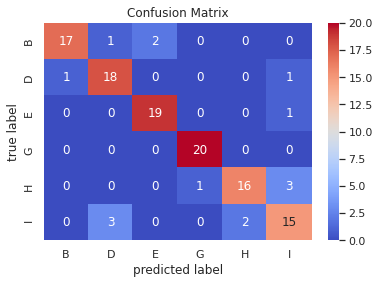

<Figure size 432x288 with 0 Axes>

In [57]:
y_true = sample_test_nlp_df["industry_code"]
y_pred = pd.read_csv("predictions.csv")["industry_code"]

# Classification report
report_dict = classification_report(
    y_true, y_pred, output_dict=True, labels=["B", "D", "E", "G", "H", "I"]
)
report_dict.pop("accuracy", None)
report_dict_df = pd.DataFrame(report_dict).T
print(report_dict_df)
report_dict_df.to_csv("classification_report.csv", index=True)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["B", "D", "E", "G", "H", "I"])
cm_df = pd.DataFrame(cm, ["B", "D", "E", "G", "H", "I"], ["B", "D", "E", "G", "H", "I"])
sns.set(font_scale=1)
cmap = "coolwarm"
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap)
plt.title("Confusion Matrix")
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.show()
plt.savefig("confusion_matrix.png")

## Step 4: Deploy the endpoint

In this step, we deploy the model artifact from **Step 3** and use for inference. We use `AutoGluonInferenceModel` defined in `ag_model.py` to create an AutoGluon model and [SageMaker model deployment](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/using_mxnet.html#deploy-mxnet-models) APIs to deploy an endpoint. If you bring your own data for inference, you may also need to update the inference script `inference.py` in the `code` folder.

In [58]:
training_job_name = ag.latest_training_job.name
print("Training job name: ", training_job_name)

Training job name:  jumpstart-example-classic-gecko-mnist-2021-11-03-21-24-48-717


In [59]:
ag_estimator = Estimator.attach(training_job_name)
ag_estimator.model_data


2021-11-03 21:33:24 Starting - Preparing the instances for training
2021-11-03 21:33:24 Downloading - Downloading input data
2021-11-03 21:33:24 Training - Training image download completed. Training in progress.
2021-11-03 21:33:24 Uploading - Uploading generated training model
2021-11-03 21:33:24 Completed - Training job completed


's3://sagemaker-us-west-2-361331411763/jumpstart-example-classic-gecko-mnist-2021-11-03-21-24-48-717/output/model.tar.gz'

In [62]:
endpoint_name = "jumpstart-example-classic-gecko-mnist-endpoint"

ag_model = AutoGluonInferenceModel(
    model_data=ag.model_data,
    role=role,
    region=region,
    framework_version="0.3.1",
    instance_type=inference_instance_type,
    entry_point="code/inference.py",
    predictor_cls=AutoGluonTabularPredictor,
    name="jumpstart-example-classic-gecko-mnist-model",
)

mnist_predictor = ag_model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    endpoint_name=endpoint_name,
)

Using already existing model: jumpstart-example-classic-gecko-mnist-model


-----!

## Step 5: Test the endpoint

We randomly select some data from the test dataset and test the endpoint.

In [63]:
test_endpoint_data = sample_test_nlp_df.sample(n=5).drop(["industry_code"], axis=1)

In [64]:
test_endpoint_data

,MDNA,positive,negative,safe
92,Management's Discussion and Analysis of Finan...,0.619140,0.690904,0.546328
84,Management’s Discussion and Analysis of Finan...,0.263842,0.498632,0.655271
31,MANAGEMENT'S DISCUSSION AND ANALYSIS OF RESUL...,0.384102,0.552067,0.169848
39,Management’s Discussion and Analysis of Finan...,0.587351,0.519351,0.205818
12,Management's Discussion and Analysis of Fina...,0.194568,0.431524,0.622537


In [65]:
mnist_predictor.predict(test_endpoint_data.values)

['G', 'I', 'D', 'D', 'I']

## Summary

1. We curated a TabText dataframe concatenating text, tabular, and categorical data.
2. We demonstrated how to do ML on a TabText (multimodal) data using [AutoGluon](https://github.com/awslabs/autogluon).
3. We showed how to deploy your trained model for inference.


## Clean Up

After you are done using this notebook, delete the model artifacts and other resources to avoid any incurring charges.

>**Caution:** You need to manually delete resources that you may have created while running the notebook, such as Amazon S3 buckets for model artifacts, training datasets, processing artifacts, and Amazon CloudWatch log groups.

For more information about cleaning up resources, see [Clean Up](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html) in the *Amazon SageMaker Developer Guide*.

In [66]:
mnist_predictor.delete_model()
mnist_predictor.delete_endpoint()

## License

The SageMaker JumpStart Industry product and its related materials are under the [Legal License Terms](https://jumpstart-cache-alpha-us-west-2.s3.us-west-2.amazonaws.com/smfinance-notebook-dependency/legal_file.txt).